<a href="https://colab.research.google.com/github/mvaldenegro/UncertaintyML-course-ESSAI-labs/blob/main/01_BNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/mvaldenegro/keras-uncertainty

In [1]:
import keras
import keras.backend as K
import tensorflow as tf
import keras_uncertainty as ku

import numpy as np

import matplotlib.pyplot as plt

# THIS TO RUN FUNCTIONAL KERAS MODELS
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

2024-01-30 22:04:12.253326: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 22:04:12.625040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 22:04:12.625276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 22:04:12.684411: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 22:04:12.806673: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 22:04:12.808319: I tensorflow/core/platform/cpu_feature_guard.cc:1

Re-create the dataset from the intro...

In [2]:
x_max = 3.14
x_min_pos = 0.5
n = 100
assert n//2 != 0, f"Only even number of data allowed (current {n})"

x = np.concatenate([np.linspace(-x_max, -x_min_pos, num=n//2), np.linspace(x_min_pos, x_max, num=n//2)])
y = np.sin(x)
x += np.random.normal(0, 0.1, x.shape)

... and the "expanded" test set

In [3]:
x_test_max = 7
n_test = 1000
x_test = np.linspace(-x_test_max, x_test_max, 1000)
y_test = np.sin(x_test)

## MC-Dropout

MC-Dropout proposes to extend the usage of Dropout, a regularization method which acts by inhibiting (i.e., zeroing-out) neurons in a given layer with a pre-specified probability $p_l$, which can be different for each layer $l$ where Dropout is applied:

![](https://drive.google.com/uc?export=view&id=1YJHNYKk9ff9-DuX8XOnYTH4xcxsIEt85)

The neurons to be inhibited are re-drawn for each forward pass.

Normally, Dropout has two behaviors:
* During training time, the aforementioned random inhibition is run for each forward pass.
* During eval (test) time, there is no inhibition, but the activation for each neuron of each layer where Dropout is applied is _rescaled_ by the dropout probability $p_l$.

The behavior during training time essentially acts as a stochastic _device_, enabling a frequentist NN to act as a Bayesian.
When the training behavior is applied also during eval time, we talk about _MonteCarlo (MC) Dropout_: the idea is that, instead of producing a deterministic output, we allow for the model to have a _distribution_ over the weights (which is essentially a combination of a multidimensional Bernoulli over the parameters of the frequentist model) which allows us to sample multiple outputs for a given input, thus enabling us to aggregate the predictions and to produce rough estimates of uncertainty.

Below, you will find an implementation of an MC Dropout layer in Keras which can be plugged into any Keras model (immediately after the layer which we want Dropout to act on) to turn the model from deterministic to probabilistic.

In [ ]:
class StochasticDropout(keras.layers.Dropout):
    """
        Applies Dropout to the input, independent of the training phase.

        Used to easily implement MC-Dropout. It is a drop-in replacement for
        the standard Keras Dropout layer, but note that this layer applies
        dropout at the training and inference phases.
    """
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        super(StochasticDropout, self).__init__(rate, noise_shape, seed, **kwargs)

    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            return K.dropout(inputs, self.rate, noise_shape, seed=self.seed)

        return inputs

**Q: _why can't we use a normal Dropout implementation, like `K.Dropout`, in our Keras model?_**

#### Notes on the implementation

In the following cells, we will be using this nomenclature:
* The architecture of the BNNs will be called "backbone"
* The backbone will be wrapped into a "regressor" structure, which implements under-the-hood MC sampling during the eval mode. These structures come already pre-implemented within `keras_uncertainty`.

All of the layers which we will implement during this lab are also taken from `keras_uncertainty` source code (with minimal changes); all of them can also be found as member of the `layers` submodule: they are re-implemented here for the sake of clarity.

In [ ]:
dropout_p = 0.2

backbone_dropout = keras.models.Sequential([
    keras.Input(shape=(1,)),
    keras.layers.Dense(units=16, activation="relu"),
    StochasticDropout(dropout_p),
    keras.layers.Dense(units=16, activation="relu"),
    StochasticDropout(dropout_p),
    keras.layers.Dense(units=1)
])

backbone_dropout.compile(loss="mean_squared_error", optimizer="adam")

Train the backbone on our dataset

In [ ]:
backbone_dropout.fit(x, y, verbose=2, epochs=750)

Let's obtain the predictions...


In [ ]:
print(backbone_dropout.predict(np.array([0,1])))

print(backbone_dropout.predict(np.array([0,1])))

**Q: _Notice that the predictions change despite the two inputs being identical. Why that?_**

Wrap the model in a `StochasticRegressor` structure to sample 25 outputs per test datapoint

In [ ]:
model_dropout = ku.models.StochasticRegressor(backbone_dropout)
y_pred_dropout = model_dropout.predict(x_test, 25)

How is the prediction returned? Let's find out...

In [ ]:
print(type(y_pred_dropout))
print(len(y_pred_dropout))
print(y_pred_dropout[0].shape, y_pred_dropout[1].shape)

The `StochasticRegressor` structure already post-processed the prediction into mean and std, which lets us reason in terms of uncertainty.

**Q: _on which dimension(s) (mc sample, test datapoint, output dimension) are the averages obtained?_**

In [ ]:
y_pred_dropout_mean, y_pred_dropout_std = y_pred_dropout

Let us prepare a function (`plot_prediction_with_uncertainty`) to plot these outputs incorporating the model uncertainty into the process. We can re-use the function from the intro with minimal modifications.

In [10]:
def plot_prediction_with_uncertainty(x, y_true, y_pred_mean, y_pred_std, x_max, x_min_pos):
  plt.scatter(x, y_true, s=5)
  plt.scatter(x, y_pred_mean, s=5)
  uncertainty_area_min = y_pred_mean - 2*y_pred_std
  uncertainty_area_max = y_pred_mean + 2*y_pred_std
  plt.fill_between(x_test.squeeze(), uncertainty_area_min, uncertainty_area_max, alpha=.25)

  yline = (
      min(y_true.min().item(), uncertainty_area_min.min().item()),
      max(y_true.max().item(), uncertainty_area_max.max().item())
  )
  plt.vlines((-x_max, -x_min_pos, x_min_pos, x_max), ymin=yline[0], ymax=yline[1], colors="black")
  x1 = np.array((-x_max, -x_min_pos))
  x2 = np.array((x_min_pos, x_max))
  y1 = np.array([yline[1], yline[1]])
  y2 = np.array([yline[0], yline[0]])
  plt.fill_between(x1, y1, y2, where=(y1 > y2), color="yellow", alpha=.3)
  plt.fill_between(x2, y1, y2, where=(y1 > y2), color="yellow", alpha=.3)

In [ ]:
plot_prediction_with_uncertainty(x_test, y_test, y_pred_dropout_mean.squeeze(), y_pred_dropout_std.squeeze(), x_max, x_min_pos)

Let us _package_ the procedure we have used for MC Dropout in a function: we'll be able to re-use it for (almost) all the other methods within this lab.

In [ ]:
def training_and_testing_pipeline(backbone, n_epochs, n_samples_test=25):
  backbone.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
  backbone.fit(x, y, epochs=n_epochs, verbose=2)
  model = ku.models.StochasticRegressor(backbone)
  print(f"Predicting {n_samples_test} samples per test datapoint...")
  y_pred_mean, y_pred_std = model.predict(x_test, n_samples_test)
  plot_prediction_with_uncertainty(x_test, y_test, y_pred_mean.squeeze(), y_pred_std.squeeze(), x_max, x_min_pos)

## MC-DropConnect

MC-DropConnect is an alternate approach to infusing stochasticity into a deterministic model: instead of inhibiting neurons' activations, we randomly inhibit _synapses_ (i.e., single connections between neurons) with a per-layer probability $p_l$:

![](https://drive.google.com/uc?export=view&id=1pRrJhFQpQBmyYzbwl24IOb_Avj9hBLxI)

Despite the striking similarity between Dropout and DropConnect, the implementation of DropConnect does not happen as a standalone module which we can _insert_ after a Dense/Linear layer: rather, we have to re-implement (or extend) this structure to accomodate this device.
This is due to a technicality. Let us denote with $x$ the input to the layer, $W$ its weights, $b$ its bias, $\sigma$ its activation function, $\hat{y}$ the output of the layer. $p$ indicates the Dropout/DropConnect probability.
* Dropout happens **after** the main calculation of the layer has been carried out
  $$
  \hat{y} = \text{Dropout}_{p}(\sigma(x^\top W+b))
  $$
  Alternatively, we might have:
  $$
  \hat{y} = \sigma(\text{Dropout}_{p}(x^\top W+b))
  $$
  This does not really matter: we can always place a Dropout layer after the Dense.
* DropConnect acts **during** the main calculation:
  $$
  \hat{y} = \sigma(x^\top \text{DropConnect}_{p}(W)+b)
  $$
  If we want to implement it, thus, we must **_insert_** it into a Dense layer:

In [ ]:
class DropConnect:
    def __init__(self, prob=0.5, drop_bias=False, noise_shape=None):
        self.prob = prob
        self.drop_bias = drop_bias
        self.noise_shape = noise_shape
        self.kernel_noise_shape = None
        self.bias_noise_shape = None

    @property
    def needs_drop(self):
        return 0.0 < self.prob < 1.0

    def sample(self, tensor, dropit=True, noise_shape=None):
        if dropit:
            return K.dropout(tensor, self.prob, noise_shape)

        return tensor

    def replace_tensor(self, tensor_train, tensor_test):
        if self.uses_learning_phase:
            return K.in_train_phase(tensor_train, tensor_test)
        else:
            return tensor_train

    def get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]

        return tuple(noise_shape)

    def get_config(self):
        config = {
            "prob": self.prob,
            "drop_bias": self.drop_bias,
            "noise_shape": self.noise_shape
        }

        return config

class DropConnectDense(DropConnect, keras.layers.Dense):
    def __init__(self, units, prob=0.5, drop_bias=False, noise_shape=None, use_learning_phase = False, **kwargs):
        DropConnect.__init__(self, prob=prob, drop_bias=drop_bias, noise_shape=noise_shape)
        keras.layers.Dense.__init__(self, units, **kwargs)

        if self.needs_drop:
            self.uses_learning_phase = use_learning_phase

    def call(self, inputs, **kwargs):
        kernel_sample = self.sample(self.kernel)
        bias_sample = self.sample(self.bias, dropit=self.drop_bias)

        outputs = K.dot(inputs, kernel_sample)

        if self.use_bias:
            outputs += bias_sample

        # This always produces stochastic outputs
        return self.activation(outputs)

    def get_config(self):
        config_dc = DropConnect.get_config(self)
        config_base = keras.layers.Dense.get_config(self)

        return dict(list(config_dc.items()) + list(config_base.items()))

**Q: _why are we using Dropout in DropConnect? Isn't one supposed to drop neurons, while the other drops weights?_**

In [ ]:
dropconnect_p = 0.05

backbone_dropconnect = keras.Sequential([
    keras.Input(shape=(1,)),
    DropConnectDense(16, prob=dropconnect_p, activation="relu"),
    DropConnectDense(16, prob=dropconnect_p, activation="relu"),
    DropConnectDense(1, prob=dropconnect_p, ),
])

In [ ]:
training_and_testing_pipeline(
    backbone_dropconnect,
    n_epochs=750,
    n_samples_test=25
)

## Deep Ensembles

Deep Ensembles are sets of Deep NNs (DNNs) which are tasked with producing multiple predictions for the same datapoint. The rationale is that the inherent randomness contained within the initialization and training process will cause the network to find different sets of parameters solving the same task, while producing possibly (widely) different responses to areas of high uncertainty (e.g., out-of-distribution data), thus finding an implicit way to estimate uncertainty even with deterministic models.

In this specific lab, we will produce ensemble of two-headed DNNs, one of which estimates the mean value, and the other estimates the variance; thus, the training process will vary, since we will have to use the Gaussian Negative Log-Likelihood loss instead of the canonical MSE we have insofar utilized.

In addition, we cannot use the `StochasticRegressor` structure we have previously made use of: this structure is a wrapper for single-component stochastic models, while Deep Ensembles are formed of multiple, separate models.

In [6]:
def regression_gaussian_nll_loss(variance_tensor, epsilon=1e-8, variance_logits=False):
    """
        Gaussian negative log-likelihood for regression, with variance estimated by the model.
        This function returns a keras regression loss, given a symbolic tensor for the sigma square output of the model.
        The training model should return the mean, while the testing/prediction model should return the mean and variance.
    """
    def nll(y_true, y_pred):
        #if variance_logits:
        #    variance_tensor = K.exp(variance_tensor)

        return 0.5 * K.mean(K.log(variance_tensor + epsilon) + K.square(y_true - y_pred) / (variance_tensor + epsilon))

    return nll

def ensemble_component_initializer():
    inp = keras.Input(shape=(1,))
    x = keras.layers.Dense(32, activation="relu")(inp)
    x = keras.layers.Dense(32, activation="relu")(x)
    mean = keras.layers.Dense(1)(x)
    var = keras.layers.Dense(1, activation="softplus")(x)

    train_model = keras.Model(inp, mean)
    pred_model = keras.Model(inp, [mean, var])

    train_model.compile(loss=regression_gaussian_nll_loss(var), optimizer="adam")

    return train_model, pred_model

n_components = 10
n_epochs = 500

ensemble = ku.models.DeepEnsembleRegressor(ensemble_component_initializer, num_estimators=n_components)
ensemble.fit(x, y, epochs=n_epochs)


Train on 100 samples
Epoch 1/500


2024-01-30 22:05:34.126292: W tensorflow/c/c_api.cc:305] Operation '{name:'training_20/Adam/dense_80/bias/v/Assign' id:6619 op device:{requested: '', assigned: ''} def:{{{node training_20/Adam/dense_80/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_20/Adam/dense_80/bias/v, training_20/Adam/dense_80/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


100/100 [==============================] - 1s 10ms/sample - loss: 0.0913
Epoch 2/500
100/100 [==============================] - 0s 199us/sample - loss: 0.0334
Epoch 3/500
100/100 [==============================] - 0s 167us/sample - loss: -0.0021
Epoch 4/500
100/100 [==============================] - 0s 195us/sample - loss: -0.0230
Epoch 5/500
100/100 [==============================] - 0s 187us/sample - loss: -0.0436
Epoch 6/500
100/100 [==============================] - 0s 283us/sample - loss: -0.0565
Epoch 7/500
100/100 [==============================] - 0s 383us/sample - loss: -0.0659
Epoch 8/500
100/100 [==============================] - 0s 341us/sample - loss: -0.0760
Epoch 9/500
100/100 [==============================] - 0s 211us/sample - loss: -0.0872
Epoch 10/500
100/100 [==============================] - 0s 198us/sample - loss: -0.0969
Epoch 11/500
100/100 [==============================] - 0s 381us/sample - loss: -0.1066
Epoch 12/500
100/100 [==============================] - 

2024-01-30 22:05:44.977380: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_21/mul' id:5437 op device:{requested: '', assigned: ''} def:{{{node loss_21/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_21/mul/x, loss_21/dense_86_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 22:05:45.199629: W tensorflow/c/c_api.cc:305] Operation '{name:'training_22/Adam/learning_rate/Assign' id:6905 op device:{requested: '', assigned: ''} def:{{{node training_22/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_22/Adam/learning_rate, training_22/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an er

100/100 [==============================] - 1s 6ms/sample - loss: 0.3806
Epoch 2/500
100/100 [==============================] - 0s 125us/sample - loss: 0.2170
Epoch 3/500
100/100 [==============================] - 0s 183us/sample - loss: 0.1056
Epoch 4/500
100/100 [==============================] - 0s 151us/sample - loss: 0.0310
Epoch 5/500
100/100 [==============================] - 0s 137us/sample - loss: -0.0120
Epoch 6/500
100/100 [==============================] - 0s 182us/sample - loss: -0.0463
Epoch 7/500
100/100 [==============================] - 0s 264us/sample - loss: -0.0674
Epoch 8/500
100/100 [==============================] - 0s 251us/sample - loss: -0.0843
Epoch 9/500
100/100 [==============================] - 0s 176us/sample - loss: -0.0949
Epoch 10/500
100/100 [==============================] - 0s 161us/sample - loss: -0.1049
Epoch 11/500
100/100 [==============================] - 0s 152us/sample - loss: -0.1112
Epoch 12/500
100/100 [==============================] - 0s 

2024-01-30 22:05:58.065556: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_22/mul' id:5564 op device:{requested: '', assigned: ''} def:{{{node loss_22/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_22/mul/x, loss_22/dense_90_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 22:05:58.272556: W tensorflow/c/c_api.cc:305] Operation '{name:'training_24/Adam/dense_88/kernel/m/Assign' id:7158 op device:{requested: '', assigned: ''} def:{{{node training_24/Adam/dense_88/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_24/Adam/dense_88/kernel/m, training_24/Adam/dense_88/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigg

100/100 [==============================] - 1s 6ms/sample - loss: 0.5226
Epoch 2/500
100/100 [==============================] - 0s 255us/sample - loss: 0.3883
Epoch 3/500
100/100 [==============================] - 0s 326us/sample - loss: 0.2856
Epoch 4/500
100/100 [==============================] - 0s 321us/sample - loss: 0.1974
Epoch 5/500
100/100 [==============================] - 0s 235us/sample - loss: 0.1140
Epoch 6/500
100/100 [==============================] - 0s 156us/sample - loss: 0.0418
Epoch 7/500
100/100 [==============================] - 0s 277us/sample - loss: -0.0180
Epoch 8/500
100/100 [==============================] - 0s 223us/sample - loss: -0.0514
Epoch 9/500
100/100 [==============================] - 0s 229us/sample - loss: -0.0667
Epoch 10/500
100/100 [==============================] - 0s 146us/sample - loss: -0.0735
Epoch 11/500
100/100 [==============================] - 0s 435us/sample - loss: -0.0779
Epoch 12/500
100/100 [==============================] - 0s 18

2024-01-30 22:06:13.683071: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_23/mul' id:5691 op device:{requested: '', assigned: ''} def:{{{node loss_23/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_23/mul/x, loss_23/dense_94_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 22:06:14.048243: W tensorflow/c/c_api.cc:305] Operation '{name:'training_26/Adam/dense_94/bias/m/Assign' id:7433 op device:{requested: '', assigned: ''} def:{{{node training_26/Adam/dense_94/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_26/Adam/dense_94/bias/m, training_26/Adam/dense_94/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an er

100/100 [==============================] - 1s 8ms/sample - loss: 0.1194
Epoch 2/500
100/100 [==============================] - 0s 99us/sample - loss: 0.0568
Epoch 3/500
100/100 [==============================] - 0s 137us/sample - loss: 0.0076
Epoch 4/500
100/100 [==============================] - 0s 135us/sample - loss: -0.0305
Epoch 5/500
100/100 [==============================] - 0s 193us/sample - loss: -0.0608
Epoch 6/500
100/100 [==============================] - 0s 192us/sample - loss: -0.0845
Epoch 7/500
100/100 [==============================] - 0s 131us/sample - loss: -0.0996
Epoch 8/500
100/100 [==============================] - 0s 191us/sample - loss: -0.1116
Epoch 9/500
100/100 [==============================] - 0s 163us/sample - loss: -0.1204
Epoch 10/500
100/100 [==============================] - 0s 281us/sample - loss: -0.1282
Epoch 11/500
100/100 [==============================] - 0s 255us/sample - loss: -0.1374
Epoch 12/500
100/100 [==============================] - 0s 

2024-01-30 22:06:24.634471: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_24/mul' id:5818 op device:{requested: '', assigned: ''} def:{{{node loss_24/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_24/mul/x, loss_24/dense_98_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 22:06:24.871892: W tensorflow/c/c_api.cc:305] Operation '{name:'training_28/Adam/dense_97/bias/v/Assign' id:7703 op device:{requested: '', assigned: ''} def:{{{node training_28/Adam/dense_97/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_28/Adam/dense_97/bias/v, training_28/Adam/dense_97/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an er

100/100 [==============================] - 1s 6ms/sample - loss: 0.3358
Epoch 2/500
100/100 [==============================] - 0s 137us/sample - loss: 0.2136
Epoch 3/500
100/100 [==============================] - 0s 152us/sample - loss: 0.1219
Epoch 4/500
100/100 [==============================] - 0s 119us/sample - loss: 0.0563
Epoch 5/500
100/100 [==============================] - 0s 90us/sample - loss: 0.0083
Epoch 6/500
100/100 [==============================] - 0s 173us/sample - loss: -0.0301
Epoch 7/500
100/100 [==============================] - 0s 105us/sample - loss: -0.0638
Epoch 8/500
100/100 [==============================] - 0s 137us/sample - loss: -0.0911
Epoch 9/500
100/100 [==============================] - 0s 176us/sample - loss: -0.1104
Epoch 10/500
100/100 [==============================] - 0s 129us/sample - loss: -0.1253
Epoch 11/500
100/100 [==============================] - 0s 119us/sample - loss: -0.1403
Epoch 12/500
100/100 [==============================] - 0s 16

2024-01-30 22:06:39.572597: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_25/mul' id:5945 op device:{requested: '', assigned: ''} def:{{{node loss_25/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_25/mul/x, loss_25/dense_102_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 22:06:39.805097: W tensorflow/c/c_api.cc:305] Operation '{name:'training_30/Adam/dense_100/kernel/v/Assign' id:7934 op device:{requested: '', assigned: ''} def:{{{node training_30/Adam/dense_100/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_30/Adam/dense_100/kernel/v, training_30/Adam/dense_100/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will 

100/100 [==============================] - 1s 6ms/sample - loss: 0.2881
Epoch 2/500
100/100 [==============================] - 0s 82us/sample - loss: 0.1682
Epoch 3/500
100/100 [==============================] - 0s 115us/sample - loss: 0.0806
Epoch 4/500
100/100 [==============================] - 0s 116us/sample - loss: 0.0175
Epoch 5/500
100/100 [==============================] - 0s 101us/sample - loss: -0.0224
Epoch 6/500
100/100 [==============================] - 0s 119us/sample - loss: -0.0459
Epoch 7/500
100/100 [==============================] - 0s 341us/sample - loss: -0.0614
Epoch 8/500
100/100 [==============================] - 0s 166us/sample - loss: -0.0770
Epoch 9/500
100/100 [==============================] - 0s 155us/sample - loss: -0.0981
Epoch 10/500
100/100 [==============================] - 0s 174us/sample - loss: -0.1185
Epoch 11/500
100/100 [==============================] - 0s 249us/sample - loss: -0.1397
Epoch 12/500
100/100 [==============================] - 0s 1

2024-01-30 22:06:51.032479: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_26/mul' id:6072 op device:{requested: '', assigned: ''} def:{{{node loss_26/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_26/mul/x, loss_26/dense_106_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 22:06:51.303592: W tensorflow/c/c_api.cc:305] Operation '{name:'training_32/Adam/dense_105/kernel/v/Assign' id:8194 op device:{requested: '', assigned: ''} def:{{{node training_32/Adam/dense_105/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_32/Adam/dense_105/kernel/v, training_32/Adam/dense_105/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will 

100/100 [==============================] - 1s 7ms/sample - loss: 0.1468
Epoch 2/500
100/100 [==============================] - 0s 88us/sample - loss: 0.0525
Epoch 3/500
100/100 [==============================] - 0s 154us/sample - loss: -0.0078
Epoch 4/500
100/100 [==============================] - 0s 300us/sample - loss: -0.0445
Epoch 5/500
100/100 [==============================] - 0s 206us/sample - loss: -0.0631
Epoch 6/500
100/100 [==============================] - 0s 316us/sample - loss: -0.0882
Epoch 7/500
100/100 [==============================] - 0s 190us/sample - loss: -0.1052
Epoch 8/500
100/100 [==============================] - 0s 288us/sample - loss: -0.1172
Epoch 9/500
100/100 [==============================] - 0s 219us/sample - loss: -0.1255
Epoch 10/500
100/100 [==============================] - 0s 246us/sample - loss: -0.1339
Epoch 11/500
100/100 [==============================] - 0s 489us/sample - loss: -0.1435
Epoch 12/500
100/100 [==============================] - 0s

2024-01-30 22:07:04.503651: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_27/mul' id:6199 op device:{requested: '', assigned: ''} def:{{{node loss_27/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_27/mul/x, loss_27/dense_110_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 22:07:04.764691: W tensorflow/c/c_api.cc:305] Operation '{name:'training_34/Adam/iter/Assign' id:8373 op device:{requested: '', assigned: ''} def:{{{node training_34/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_34/Adam/iter, training_34/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node

100/100 [==============================] - 1s 8ms/sample - loss: 0.4700
Epoch 2/500
100/100 [==============================] - 0s 397us/sample - loss: 0.3374
Epoch 3/500
100/100 [==============================] - 0s 417us/sample - loss: 0.2343
Epoch 4/500
100/100 [==============================] - 0s 200us/sample - loss: 0.1499
Epoch 5/500
100/100 [==============================] - 0s 283us/sample - loss: 0.0851
Epoch 6/500
100/100 [==============================] - 0s 214us/sample - loss: 0.0333
Epoch 7/500
100/100 [==============================] - 0s 138us/sample - loss: -0.0121
Epoch 8/500
100/100 [==============================] - 0s 396us/sample - loss: -0.0488
Epoch 9/500
100/100 [==============================] - 0s 120us/sample - loss: -0.0775
Epoch 10/500
100/100 [==============================] - 0s 165us/sample - loss: -0.1027
Epoch 11/500
100/100 [==============================] - 0s 132us/sample - loss: -0.1187
Epoch 12/500
100/100 [==============================] - 0s 24

2024-01-30 22:07:14.726291: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_28/mul' id:6326 op device:{requested: '', assigned: ''} def:{{{node loss_28/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_28/mul/x, loss_28/dense_114_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 22:07:14.969787: W tensorflow/c/c_api.cc:305] Operation '{name:'training_36/Adam/learning_rate/Assign' id:8641 op device:{requested: '', assigned: ''} def:{{{node training_36/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_36/Adam/learning_rate, training_36/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an e

100/100 [==============================] - 1s 6ms/sample - loss: 0.7069
Epoch 2/500
100/100 [==============================] - 0s 74us/sample - loss: 0.4581
Epoch 3/500
100/100 [==============================] - 0s 125us/sample - loss: 0.2650
Epoch 4/500
100/100 [==============================] - 0s 159us/sample - loss: 0.1316
Epoch 5/500
100/100 [==============================] - 0s 172us/sample - loss: 0.0334
Epoch 6/500
100/100 [==============================] - 0s 125us/sample - loss: -0.0341
Epoch 7/500
100/100 [==============================] - 0s 122us/sample - loss: -0.0810
Epoch 8/500
100/100 [==============================] - 0s 130us/sample - loss: -0.1110
Epoch 9/500
100/100 [==============================] - 0s 185us/sample - loss: -0.1248
Epoch 10/500
100/100 [==============================] - 0s 150us/sample - loss: -0.1348
Epoch 11/500
100/100 [==============================] - 0s 109us/sample - loss: -0.1411
Epoch 12/500
100/100 [==============================] - 0s 13

2024-01-30 22:07:21.617119: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_29/mul' id:6453 op device:{requested: '', assigned: ''} def:{{{node loss_29/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_29/mul/x, loss_29/dense_118_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 22:07:21.849736: W tensorflow/c/c_api.cc:305] Operation '{name:'training_38/Adam/dense_118/bias/v/Assign' id:8953 op device:{requested: '', assigned: ''} def:{{{node training_38/Adam/dense_118/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_38/Adam/dense_118/bias/v, training_38/Adam/dense_118/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger 

100/100 [==============================] - 1s 6ms/sample - loss: 0.5699
Epoch 2/500
100/100 [==============================] - 0s 75us/sample - loss: 0.4454
Epoch 3/500
100/100 [==============================] - 0s 106us/sample - loss: 0.3397
Epoch 4/500
100/100 [==============================] - 0s 102us/sample - loss: 0.2557
Epoch 5/500
100/100 [==============================] - 0s 85us/sample - loss: 0.1829
Epoch 6/500
100/100 [==============================] - 0s 99us/sample - loss: 0.1248
Epoch 7/500
100/100 [==============================] - 0s 85us/sample - loss: 0.0737
Epoch 8/500
100/100 [==============================] - 0s 100us/sample - loss: 0.0308
Epoch 9/500
100/100 [==============================] - 0s 103us/sample - loss: -0.0016
Epoch 10/500
100/100 [==============================] - 0s 75us/sample - loss: -0.0248
Epoch 11/500
100/100 [==============================] - 0s 100us/sample - loss: -0.0426
Epoch 12/500
100/100 [==============================] - 0s 91us/samp

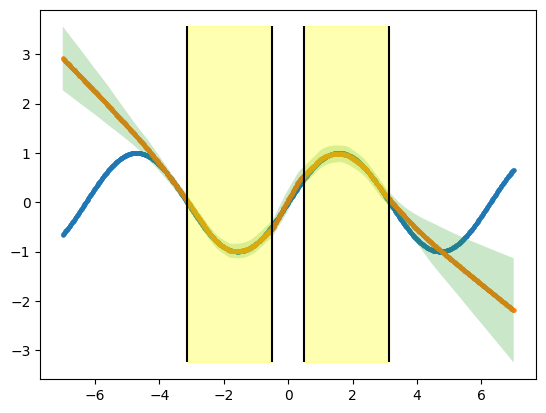

In [11]:
ensemble_means = []
ensemble_variances = []

for test_component in ensemble.test_estimators:
  mean, var = test_component.predict(x_test)
  ensemble_means.append(mean)
  ensemble_variances.append(var)

ensemble_mean = np.mean(ensemble_means, axis=0)
ensemble_var = (np.mean(ensemble_variances + np.square(ensemble_means), axis=0) - np.square(ensemble_mean)).clip(0.0)
ensemble_std = np.sqrt(ensemble_var)

plot_prediction_with_uncertainty(x_test, y_test, ensemble_mean.squeeze(), ensemble_std.squeeze(), x_max, x_min_pos)

Tip: You may also use the structure `models.DeepEnsembleRegressor` from `keras_uncertainty` to help with the training/testing.

## Variational Inference (VI) - BayesByBackprop

VI takes a different approach to training BNNs.
Instead of using tricks to modify deterministic layers into stochastic ones, it uses a full Bayesian approach, which consists in defining a _prior distribution_ on the parameters $\Theta \sim P(\Theta)$ and computing a _posterior distribution_ $P(\Theta\vert \mathcal{D})$, which equates to an _update in knowledge_ concerning the parameters $\Theta$ following the observed data $\mathcal{D}$.
The information conveyed by the data, which showcases the empirical "plausibility" of the data according to the current set of parameters is the _likelihood_ $P(\mathcal{D}\vert \Theta)$, which is usually the ideological "driver" toward the deterministic ML models: optimize parameters to maximize the likelihood.

Using Bayes' theorem, we can find a rule for updating the prior distribution according to the evidence brought on by the likelihood:

$$
P(\Theta \vert \mathcal{D}) = \frac{P(\mathcal{D}\vert \Theta)\cdot P{\Theta}}{P(\mathcal{D})}
$$

The hard part of the computation above is the denominator, which would require to either
* know the data generating process (which is usually unknown in ML applications), or
* calculate a very computationally-intensive integral, which obtains $P(\mathcal{D})$ from _marginalization_ of the likelihood.

There are several ways to solve this problem in an approximate way, VI being one of them.
The foundational idea is to find an approximation of the posterior, which we call _variational posterior_ ($q$), from which we can sample the parameters of the model and obtain a prediction.
The variational posterior is trained by trying to _minimize_ the Kullback-Leibler (KL) divergence between itself and the true posterior.

Given the unknown nature of the true posterior, the KL divergence is approximated by the following loss function:
$$
\mathcal{L} = \frac{1}{n} \sum_{i=1}^{n} \left[ \log \underbrace{q(\theta_i)}_{\text{var. post.}} - \log \underbrace{P(\theta_i)}_{\text{prior}} - \log \underbrace{P(\mathcal{D}\vert \theta_i)}_{\text{likelihood}} \right]
$$
The $\theta_i$'s in the formula are samples from the variational posterior: the loss is hence a mean over multiple of these samples.

The immediate architectural difference between previously seen NNs is that we now have to **explicitly** represent the distribution $q$ for each of the layers. The most common choice is to use a Gaussian distribution, which requires the layers to be parameterized by a mean $\mu$ and a variance $\Sigma$, which is usually a diagonal matrix (→ each parameter of the layer is parameterized by a scalar mean and a scalar variance).
A backward pass would calculate the gradient for all of these parameters: hence, at each step of (S)GD we update both the mean and variance.
Note the following:
* To allow for the differentiability of the loss function w.r.t. the parameters $\mu$ and $\Sigma$, the sampling process is replaced by the _reparameterization trick_: instead of sampling directly from $q$, we take $\mu$ and add to it $\Sigma$ times a random sample from a standard Gaussian. Since the source of randomness is independent from $\mu, \Sigma$, it gets eliminated in the differentiation process and we can train the parameters via GD.
* Since GD could cause the values of the diagonals of $\Sigma$ to fall below 0, we elect a vector $\rho$ as a replacement for the training process, and get $\text{diag}(\Sigma) = \frac{1}{1+e^{-\rho}} = \text{softplus}(\rho)$. The softplus function transforms a real number into a positive number, thus ensuring that the diagonal of the variance matrix will always contain positive scalars.

The [paper](https://arxiv.org/pdf/1505.05424.pdf) introducing this type of VI-based training calls this process BayesByBackprop.
Its authors propose adopting a mixture-of-Gaussians prior with 2 component.
These components have 0 mean and two different diagonal variance matrices $\Sigma_1 = \sigma_1 I$ and $\Sigma_2 = \sigma_2 I$, with $\sigma_1, \sigma_2 \in \mathbb{R}^+$.
The prevalence of component 1 w.r.t. component 2 is regulated by a scalar $pi\in[0,1]$.
For each parameter $\theta^{(j)} \in \Theta$, we have the following prior

$$
P(\theta^{(j)}) = \pi [\mathcal{N}(0, \sigma_1)(\theta^{(j)})] + (1-\pi) [\mathcal{N}(0, \sigma_2)(\theta^{(j)})].
$$

In [ ]:
class VariationalDense(keras.layers.Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 initializer_sigma=0.1,
                 prior=True,
                 prior_sigma_1=1.0,
                 prior_sigma_2=0.5,
                 prior_pi=0.5,
                 bias_distribution=False,
                 **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = keras.activations.get(activation)
        self.initializer_sigma = initializer_sigma
        self.prior = prior
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)
        self.bias_distribution = bias_distribution
        self.uses_learning_phase = True

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return [(None, self.units)]

    def build(self, input_shape):
        feature_dims = input_shape[-1]
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(feature_dims, self.units),
                                         initializer=keras.initializers.normal(stddev=self.initializer_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=keras.initializers.normal(stddev=self.initializer_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(feature_dims, self.units),
                                          initializer=keras.initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=keras.initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                        trainable=self.bias_distribution)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = K.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * K.random_normal(self.kernel_mu.shape)

        bias_sigma = K.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * K.random_normal(self.bias_mu.shape)

        loss = self.kl_loss(kernel, self.kernel_mu, kernel_sigma) + self.kl_loss(bias, self.bias_mu, bias_sigma)

        self.add_loss(K.in_train_phase(loss, 0.0))

        # This always produces stochastic outputs
        return self.activation(K.dot(inputs, kernel) + bias)

    def kl_loss(self, w, mu, sigma):
        return self.kl_weight * K.mean(ku.distributions.gaussian.log_probability(w, mu, sigma) - self.prior * self.log_prior_prob(w))

    def log_prior_prob(self, w):
        return K.log(self.prior_pi_1 * ku.distributions.gaussian.probability(w, 0.0, self.prior_sigma_1) +
                     self.prior_pi_2 * ku.distributions.gaussian.probability(w, 0.0, self.prior_sigma_2))

    def get_config(self):
        config = {'units': self.units,
                  'kl_weight': self.kl_weight,
                  'activation': self.activation.__name__,
                  #'bias': self.bias,
                  'prior': self.prior,
                  'prior_sigma_1': self.prior_sigma_1,
                  'prior_sigma_2': self.prior_sigma_2,
                  'prior_pi_1': self.prior_pi_1}
        base_config = super(VariationalDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
n_plus = 1000
assert n//2 != 0, f"Only even number of data allowed (current {n})"

x_plus = np.concatenate([np.linspace(-x_max, -x_min_pos, num=n_plus//2), np.linspace(x_min_pos, x_max, num=n_plus//2)])
y_plus = np.sin(x)
x_plus += np.random.normal(0, 0.1, x_plus.shape)

In [ ]:
num_neurons = 16
batch_size = 32
num_batches = np.ceil((len(x)*100)/batch_size)
n_epochs = 200

backbone_vi = keras.Sequential([
    keras.Input((1,)),
    VariationalDense(num_neurons, kl_weight=1/num_batches, activation="relu"),
    VariationalDense(num_neurons, kl_weight=1/num_batches, activation="relu"),
    VariationalDense(1, kl_weight=1/num_batches),
])

training_and_testing_pipeline(backbone_vi, n_epochs, n_samples_test=25)

## Flipout

Flipout aims at tackling one of VI's main issues: the necessity to produce multiple samples per datapoint.
It builds upon BayesByBackprop by introducing a per-datapoint perturbation to the parameters sampled from the variational posterior.

BayesByBackprop had the following procedure for sampling (reparameterization trick):
$$
\theta^{(j)} = \mu^{(j)} + \underbrace{\sigma^{(j)} \cdot \mathcal{N}(0,1)}_{\text{perturbation } \delta_{\theta^{(j)}}}
$$
This perturbation is the same for all datapoints $i \in \{1,\dots,n\}$.

Flipout introduces a per-datapoint perturbation by randomly flipping the sign of the input incoming to the layer and its output (equivalent to directly perturbing the parameters).
If we suppose the layer having no bias, we have, for datapoint $i$:
$$
y_i = \text{Activation}\left(\underbrace{r_i}_{q\times 1} \odot \left[\underbrace{\Theta}_{q\times p} \underbrace{(x_i \odot s_i)^\top}_{p\times 1} \right]\right)
$$
Where $r_i$ and $s_i$ are samples from the Rademacher distribution (probability distribution which assigns equal probability to scalars -1 and 1).
The effect of $r_i$ and $s_i$ is to effectively create different per-datapoint perturbations, speeding up VI and rendering it more stable.

In [ ]:
class FlipoutDense(keras.layers.Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 initializer_sigma=0.1,
                 prior=True,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5,
                 bias_distribution=False,
                  **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = keras.activations.get(activation)
        self.prior = prior
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.initializer_sigma = initializer_sigma
        self.uses_learning_phase = True
        self.bias_distribution = bias_distribution

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return [(None, self.units)]

    def build(self, input_shape):
        feature_dims = input_shape[-1]
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(feature_dims, self.units),
                                         initializer=keras.initializers.normal(stddev=self.initializer_sigma),
                                         trainable=True)

        # -3.0 is an approximation for 0.0 with softplus, softplus(-3.0) ~ 0.0
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(feature_dims, self.units),
                                          initializer=keras.initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                          trainable=True)

        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=keras.initializers.normal(stddev=self.initializer_sigma),
                                       trainable=True)

        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=keras.initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                        trainable=self.bias_distribution)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = K.softplus(self.kernel_rho)
        kernel_perturb = kernel_sigma * K.random_normal(self.kernel_mu.shape)
        kernel = self.kernel_mu + kernel_perturb

        if self.bias_distribution:
            bias_sigma = K.softplus(self.bias_rho)
            bias = self.bias_mu + bias_sigma * K.random_normal(self.bias_mu.shape)
        else:
            bias = self.bias_mu

        loss = self.kl_loss(kernel, self.kernel_mu, kernel_sigma)

        if self.bias_distribution:
            loss += self.kl_loss(bias, self.bias_mu, bias_sigma)

        self.add_loss(K.in_train_phase(loss, 0.0))

        input_shape = K.shape(inputs)
        batch_shape = input_shape[:-1]
        sign_input = ku.distributions.rademacher.sample(input_shape)
        sign_output = ku.distributions.rademacher.sample(K.concatenate([batch_shape, K.expand_dims(self.units, 0)], axis=0))
        perturbed_inputs = K.dot(inputs * sign_input, kernel_perturb) * sign_output

        outputs = K.dot(inputs, self.kernel_mu)
        outputs += perturbed_inputs
        outputs += bias

        # This always produces stochastic outputs
        return self.activation(outputs)

    def kl_loss(self, w, mu, sigma):
        return self.kl_weight * K.mean(ku.distributions.gaussian.log_probability(w, mu, sigma) - self.prior * self.log_prior_prob(w))

    def log_prior_prob(self, w):
        return K.log(self.prior_pi_1 * ku.distributions.gaussian.probability(w, 0.0, self.prior_sigma_1) +
                     self.prior_pi_2 * ku.distributions.gaussian.probability(w, 0.0, self.prior_sigma_2))

    def get_config(self):
        config = {'units': self.units,
                  'kl_weight': self.kl_weight,
                  'activation': self.activation.__name__,
                  #'bias': self.bias,
                  'prior': self.prior,
                  'prior_sigma_1': self.prior_sigma_1,
                  'prior_sigma_2': self.prior_sigma_2,
                  'prior_pi': self.prior_pi_1}
        base_config = super(FlipoutDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
num_neurons = 16
batch_size = 32
num_batches = np.ceil((len(x)*100)/batch_size)
n_epochs = 700

backbone_flip = keras.Sequential([
    keras.Input((1,)),
    FlipoutDense(num_neurons, kl_weight=1/num_batches, activation="relu"),
    FlipoutDense(num_neurons, kl_weight=1/num_batches, activation="relu"),
    FlipoutDense(1, kl_weight=1/num_batches),
])

training_and_testing_pipeline(backbone_flip, n_epochs, n_samples_test=25)

## The task for today

Split in groups. Each group is to be assigned one of the methods here implemented. Your goal is to train a BNN on MNIST using one of these methods.

Tips:
* You may download the dataset MNIST using this command

  `(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()`
  
  Be aware that the images will have dtype `uint8` and the pixel values will range from 0 to 255. For a NN to train well, you should convert them to `float32` and have them in the range [0, 1] or [-1, 1] or any interval close to these values.
* Until now, we have used the `StochasticRegressor` structure from `keras_uncertainty`. This may not be the optimal choice for MNIST...